# Подгрузка солвера ODE

In [101]:
# Vector stuff

import numpy as np

class FVec(np.ndarray): # function vector
    
    def __new__(cls, a):
        obj = np.asarray(a).view(cls)
        return obj
        
    def __call__(self, point):
        point = Vec(point)
        res = np.array(list(map(lambda f: f(point), self)))
        return res

class Vec(np.ndarray):
    
    def __new__(cls, a):
        obj = np.asarray(a).view(cls)
        return obj

    @property
    def x(self):
        return self[0]

    @property
    def y(self):
        return self[1]

    @property
    def z(self):
        return self[2]

class TimeRange:

    def __init__(self, bounds):

        self.start = bounds[0]
        self.end = bounds[1]

# Solver stuff

def euler_step(fvec, vecs, i, h):

    vec = vecs[i-1]

    next_vec = vec + fvec(vec) * h
    
    return next_vec

def rk4_step(fvec, vecs, i, h):

    vec = vecs[i-1]
    
    k1 = fvec(vec)
    k2 = fvec(vec + h/2 * k1)
    k3 = fvec(vec + h/2 * k2)
    k4 = fvec(vec + h * k3)

    next_vec = vec + h/6 * (k1 + 2 * k2 + 2 * k3 + k4)

    return next_vec

def solveODE(fvec, vec0, time, h, main_step, warmup_num = 0, warmup_step = euler_step):

    N = int((time.end - time.start) / h)
    
    vecs = np.empty((N + 1, vec0.size))
    vecs[0] = vec0

    for i in range(1, warmup_num + 1):

        vecs[i] = warmup_step(fvec, vecs, i, h)

    for i in range(warmup_num + 1, N + 1):

        vecs[i] = main_step(fvec, vecs, i, h)    

    return vecs

# Plot stuff

%matplotlib inline
import matplotlib.pyplot as plt

def plotSolution(vecs):

    fig = plt.figure().add_subplot(projection = '3d')
    plt.plot(*vecs.T, lw = 0.5)

def plotSolution2D(vecs, plot_label):

    x = vecs.T[0]
    y = vecs.T[1]
    z = vecs.T[2]
    plt.plot(x, y, label = plot_label)

# Решение методом стрельбы

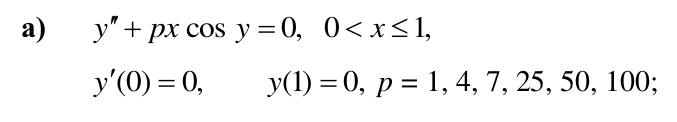

/tmp/ipykernel_2662/4006361954.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  obj = np.asarray(a).view(cls)


[0.16511556]


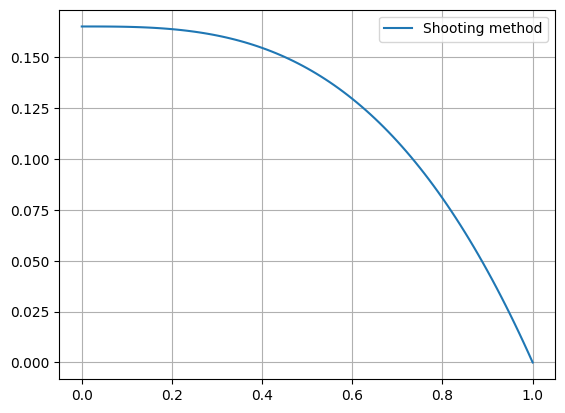

In [161]:
'''
[Метод стрельбы]

Преобразуем в автономную систему ОДУ первого порядка:

x' = 1
y' = z
z' = -p*x*cos(y)

В точке 0 для формирования Задачи Коши не хватает условия на y0
Пусть y0 = teta, параметр

Будем решать ЗК с x0, y0 = teta, z0
Получим решение y(t, teta)

Рассмотрим функцию:
F(teta) = y1 - y(1, teta)

Чтобы удовлетворить краевые условия, нужно найти teta, при котором:

y(1, teta) = y1, т.е:

F(teta) = 0

Таким образом, задача сводится к поиску корню уравнения.
'''

# Parameters

ps = [1, 4, 7, 25, 50, 100]
p = ps[0]
time = TimeRange([0., 1.])
h_std = 0.01

# Initial values

def boundaryConidtionFit(teta):

    x0 = 0
    y0 = teta
    z0 = 0

    vec0 = Vec([x0, y0, z0])

    fx = lambda point: 1
    fy = lambda point: point.z
    fz = lambda point: -p * point.x * np.cos(point.y)
    
    fvec = FVec([fx, fy, fz])

    vecs = solveODE(fvec, vec0, time, h_std, rk4_step)
    
    y1 = 0
    
    return y1 - vecs[-1][1]


from scipy import optimize

sol = optimize.root(boundaryConidtionFit, 0)
print(sol.x)

# Подставим подобранное начальное условие

x0 = 0
y0 = sol.x
z0 = 0

vec0 = Vec([x0, y0, z0])

fx = lambda point: 1
fy = lambda point: point.z
fz = lambda point: -p * point.x * np.cos(point.y)

fvec = FVec([fx, fy, fz])

vecs = solveODE(fvec, vec0, time, h_std, rk4_step)

plotSolution2D(vecs, "Shooting method")
plt.legend()
plt.grid()

# Решение методов квазилинеаризации

0.1650992054738079

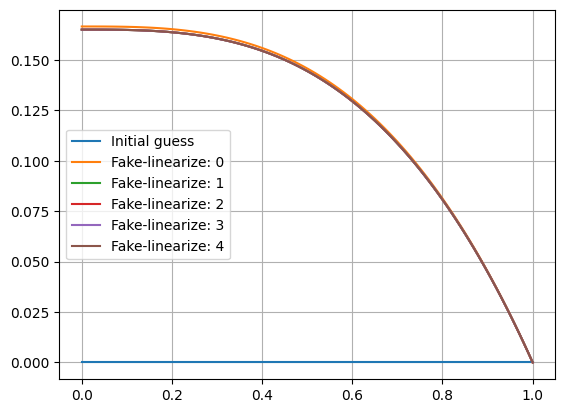

In [160]:
'''
[Метод квазилинеаризации]

Метод квазилинеаризации заключается в том, что
мы представляем итоговое решение y(x) как отклонение nu(x)
от грубого решения y0(x), которое удовлетворяет краевым условиям:

y(x) = y0(x) + nu(x)

y0(1) = 0
y0'(0) = 0

Тогда перепишем диффур:

y''(x) = y0''(x) + nu''(x)

При этом правая часть примет вид (ЛИАНЕРИЗУЕМ f(x, y)):
f(x, y) = f(x, y0 + nu) = f(x, y0) + nu * df(x, y0)/dy 

Итого:
nu''(x) + y0''(x) = f(x, y0) + nu * df(x, y0)/dy

nu''(x) = nu * df(x, y0)/dy + f(x, y0) - y0''(x) = new_f(x, nu)

nu(1) = 0 
nu'(0) = 0

Нулевость краевых условий обусловлена тем, что nu(x) - отклонение
грубого решения y0(x) от истинного. Но y0(x) было подобрано так,
чтобы удовлетворять краевым условиям. Т.е. на краях y0(x) = y(x) и, следовательно,
отклонение в этих точках должно быть нулевое.

ЧРЕЗВЫЧАЙНО ВАЖНО, подобрать грубое решение y0 так, чтобы оно
соответствовало начальным условиям. Чем лучше соответствие, тем лучше будет резальтат.

Например, начальному условию y'(0) = 0
удовлетворяют и y(x) = cos(2pi * x), и y(x) = 0. При центральной разностной схеме
эти функции одинаково хороши. Но при аппроксимации с помощью forward-difference лучше
y(x) = 0, т.к. для косинуса производная-вперёд будет немного отлична от нуля. 

Полученная краевая задача является линейной, т.к. new_f(x, nu)
линейно зависит от nu
'''

'''
[Метод прогонки]

Метод заключается в сведении задачи решения диффура
к задаче решения линейных алгебраических уравнений.

Для этого нужно записать аппроксимацию диффура в виде
конечных разностей. Для аппроксимации используем центральную схему:

nu''(x0) = [nu(x0+h) - 2*nu(x0) + nu(x0-h)] / [h^2]

Спроецируем на равномерную сетку:

nu''_{n} = [nu_{n+1} - 2*nu_{n} + nu_{n-1}] / [h^2]

Исходное уравнение можно переписать в виде:

nu''(x) = nu * A(x) + B(x)

A(x) = df(x, y0)/dy 
B(x) = f(x, y0) - y0''(x)

Правая часть после проецирования:

nu''_{n} = nu_{n} * A_{n} + B_{n}

Подставляя левую часть выраженную через nu_{n-1}, nu_{n}, nu_{n+1},
приходим с уравнению, запишем его в унифицированнйо форме:

nu_{n-1}*a_{n} + nu_{n}*b_{n} + nu_{n+1}*c_{n} = d_{n}

a_{n} = 1
b_{n} = - 2 - A_{n} * h^2
c_{n} = 1
d_{n} = B_{n} * h^2

n принадлежит [1, N-1]

Аналогичные действия проведём с краевыми условиями:

y(1) = 0
<=>
y_{N} * a_{N}= 0
a_{N} = 1
d_{N} = 0

y'(0) = 0
<=>
[y_{1} - y_{0}] / h = 0

или:

y_{0} * a_{0} + y_{1} * b_{0} = 0

a_{0} = -1/h
b_{0} = 1/h
d_{0} = 0

запишем полученные уравнения в виде матрицы:


a_{0} b_{0}                      d_{0}
a_{1} b_{1} c_{1}                d_{1}
      a_{2} b_{2} c_{2}          d_{2}
                        ...
                        a_{N}    d_{N}

Исключим x_{0} из первого уравнения:
x_{0} = [d_{0} - x_{1} * b_{0}] / a_{0}
или
x_{0} = P_{0} * x_{1} + Q_{0}

P_{0} = -b_{0} / a_{0} = 1
Q_{0} = d_{0} / a_{0} = 0

Подставим во второе:
a_{1} * [P_{0} * x_{1} + Q_{0}] + b_{1} * x{1} + c_{1} * x{2} = d_{1}

Выразим x_{1}:
x_{1} = [d_{1} - c_{1} * x_{2} - a_{1}*Q_{0}] / [a_{1}*P_{0} + b_{1}]
или
x_{1} = P_{1} * x_{2} + Q_{1}

P_{1} = [-c_{1}] / [a_{1}*P_{0} + b_{1}]
Q_{1} = [d_{1} - a_{1}*Q{0}] / / [a_{1}*P_{0} + b_{1}]

Обобщая:
x_{n} = P_{n} * x_{n+1} + Q_{n}

P_{n} = [-c_{n}] / [a_{n}*P_{n-1} + b_{n}]
Q_{n} = [d_{n} - a_{n}*Q{n-1}] / [a_{n}*P_{n-1} + b_{n}]

Таким образом, зная все P_{n}, Q_{n}, а также зная x_{N}
можно найти все x_{n}

Метод прогонки состоит из двух этапов:
1. Прямая прогонка: вычисляем P_{n}, Q_{n}
2. Обратная прогонка: начиная от x_{N} последовательно вычисляем x_{n}
'''

# Parameters

ps = [1, 4, 7, 25, 50, 100]
p = ps[0]
time = TimeRange([0., 1.])
h_std = 0.01
N = int(1/h_std)
SampleSize = N + 1

x = np.zeros(SampleSize)
for n in range(0, SampleSize):

    x[n] = h_std * n

y0 = np.zeros(SampleSize)
for n in range(0, SampleSize):

    y0[n] = 0
    
plt.plot(x, y0, label = f'Initial guess')

ddy0 = lambda n: (y0[n+1] - 2*y0[n] + y0[n-1]) / h_std**2

f = lambda x, y:  -p * x * np.cos(y)
dfdy = lambda x, y: (f(x,y + h_std) - f(x,y - h_std))/ (2 * (h_std))

# nu'' = A * nu + B
A = lambda n: dfdy(x[n], y0[n])
B = lambda n: f(x[n], y0[n]) - ddy0(n) # фактически это невязка грубого решения

# Решаем линеаризованное уравнение с помощью метода прогонки:
IterationNum = 5
for iteration_id in range(IterationNum):

    # уточнение грубого решения
    nu = np.zeros(SampleSize)

    a = np.zeros(SampleSize)
    b = np.zeros(SampleSize)
    c = np.zeros(SampleSize)
    d = np.zeros(SampleSize)
    
    # y'(0) = 0
    a[0] = -1
    b[0] = 1
    c[0] = 0
    d[0] = 0

    # y(1) = 0
    a[-1] = 0
    b[-1] = 1
    c[-1] = 0
    d[-1] = 0

    P = np.zeros(SampleSize)
    Q = np.zeros(SampleSize)
    
    P[0] = -b[0] / a[0]
    Q[0] = d[0] / a[0]

    # Прямая прогонка: вычисляем P и Q
    for n in range(1, SampleSize-1):

        a[n] = 1.
        b[n] = -2. - A(n) * h_std**2
        c[n] = 1.
        d[n] = B(n) * h_std**2
        
        P[n] = (-c[n]) / (a[n]*P[n-1] + b[n])
        Q[n] = (d[n] - a[n]*Q[n-1]) / (a[n]*P[n-1] + b[n])

    # Находим значение в последней точке:

        # x[N-1] = P[N-1] * x[N] + Q[N-1] 
        # x[N] * b[N] + a[N] * (P[N-1] * x[N] + Q[N-1]) = d[N]
        # x[N] = (d[N] - a[N] * Q[N-1]) / (b[N] + a[N] * P[N-1])
        
    nu[-1] = (d[-1] - a[-1] * Q[-2]) / (b[-1] + a[-1] * P[-2])

    # Обратная прогонка: x_{n} = P_{n} * x_{n+1} + Q_{n}
    for n in range(SampleSize-2, -1, -1):

        nu[n] = P[n]*nu[n+1] + Q[n]
        y0[n] = y0[n] + nu[n] # уточняем грубое решение
        
    plt.plot(xs, y0, label = f'Fake-linearize: {iteration_id}')

plt.legend()
plt.grid()
y0[0]

# Метод периодической прогонки

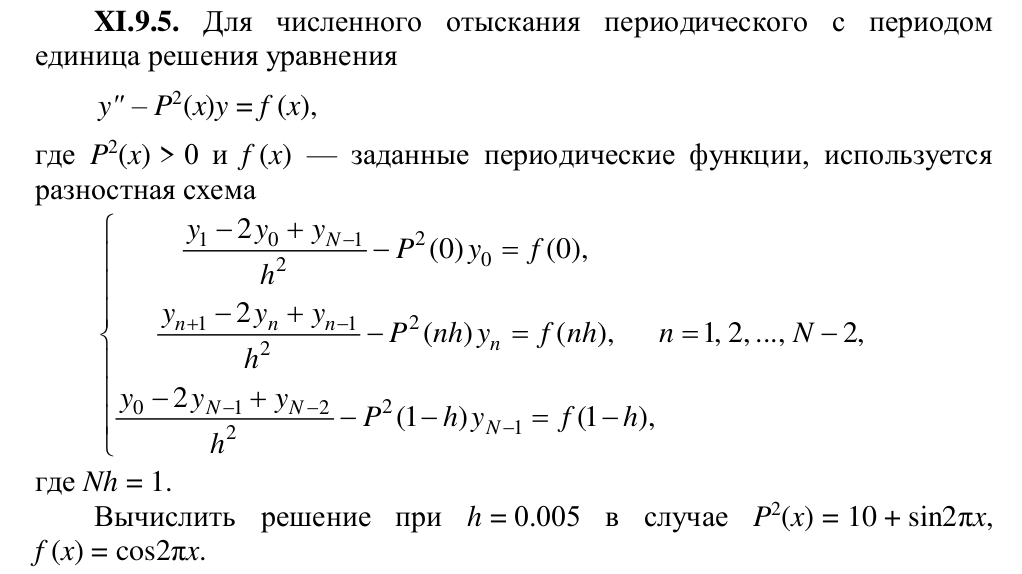

-0.020839051325527935

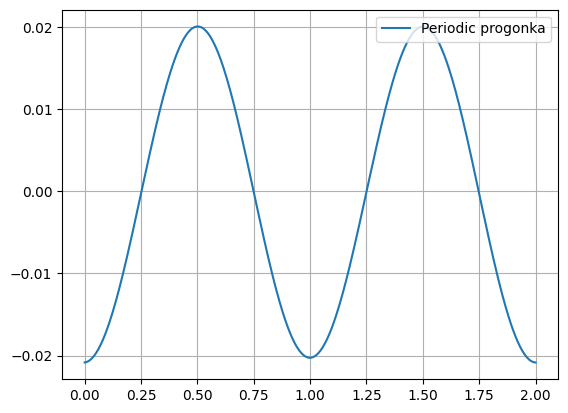

In [163]:
'''
Краевое условие в случае периодической функции имеет следующий вид:

y(x) = y(x + T), T - период
y'(x) = y'(x + T)

'''

P = lambda x: 10 + np.sin(2 * np.pi * x)
f = lambda x: np.cos(2 * np.pi * x)

h = 0.005
iteration_num = 2
N = int(1/h) * iteration_num
SampleSize = N + 1

y = np.zeros(SampleSize)
x = np.array([h * n for n in range(SampleSize)])

a = np.zeros(SampleSize)
b = np.zeros(SampleSize)
c = np.zeros(SampleSize)
d = np.zeros(SampleSize)

a[0] = 1
b[0] = 2 + P(x[0]) * h**2
c[0] = 1 # y_n{N-1}
d[0] = f(x[0]) * h**2

a[-1] = 1 # y_{0}
b[-1] = 2. + P(x[-1]) * h**2
c[-1] = 1
d[-1] = f(x[-1]) * h**2

alfa = np.zeros(SampleSize)
beta = np.zeros(SampleSize)
gamma = np.zeros(SampleSize)

alfa[1] = c[0] / b[0]
beta[1] = -d[0] / b[0]
gamma[1] = a[0] / b[0]

# Прямая прогонка: вычисляем alfa, beta, gamma
for n in range(1, SampleSize):

    if n > 1:

        divisor = (b[n-1] - alfa[n-1] * a[n-1])
        
        alfa[n] = c[n-1] / divisor
        beta[n] = (a[n-1] * beta[n-1] - d[n-1]) / divisor
        gamma[n] = (a[n-1] * gamma[n-1]) / divisor
    
    a[n] = 1.
    b[n] = 2. + P(x[n]) * h**2
    c[n] = 1.
    d[n] = f(x[n]) * h**2
    
mu = np.zeros(SampleSize)
nu = np.zeros(SampleSize)

divisor = (a[-1] * (alfa[-1] + gamma[-1]) - b[-1])
mu[-1] = -c[-1] / divisor
nu[-1] = (d[-1] - a[-1] * beta[-1]) / divisor

# Обратная прогонка x 1: вычисляем mu, nu
for n in range(SampleSize-2, -1, -1):

    mu[n] = alfa[n+1] * mu[n+1] + gamma[n+1] * mu[-1]
    nu[n] = beta[n+1] + alfa[n+1] * nu[n+1] + gamma[n+1] * nu[-1]

y[0] = nu[0] / (1 - mu[0])
y[-1] = mu[-1] * y[0] + nu[-1] 

# Обратная прогонка x 2: вычисляем оставшиесу значения функции
for n in range(SampleSize-2, 0, -1):

    y[n] = alfa[n+1] * y[n+1] + beta[n+1] + gamma[n+1] * y[-1]

plt.plot(x, y, label = f'Periodic progonka')

plt.legend(loc = 'upper right')
plt.grid()
y[0]